###  MicroGrad demo

In [ ]:
%pip install micrograd
import random
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from micrograd.engine import Value
from micrograd.nn import Neuron, Layer, MLP

In [ ]:
np.random.seed(1337)
random.seed(1337)

# Micrograd
### Micrograd ist eine Tool von Andrej Karpathy, mit dem wir neuronale Netze von Hand entwickeln können, um die internen Mechanismen besser zu verstehen.
Wir werden uns im Folgenden anschauen, wie ein kleines Neuronales Netzwerk aussieht, und wie wir es auf einem kleinen Datensatz trainieren können.
Dann werden wir das Konzept ausweiten, um einen komplexen Datensatz zu klassifizieren.

### Daten erstellen
Um unser Neuronales Netz auszuprobieren, werden wir nun einen Datensatz erstellen, den wir als Eingabe verwenden.

In [ ]:
from sklearn.datasets import make_moons, make_blobs
X, y = make_moons(n_samples=100, noise=0.1)

y = y*2 - 1 # y-werte normalisieren
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

### Modell erstellen
Nun erstellen wir ein Modell, welches die zwei Koordinaten eines Punktes als Eingabe verwendet und uns eine Klasse (Rot/Blau) als Ausgabe gibt.
Hierfür verwenden wir ein Multi-Layer-Perceptron mit zwei internen Schichten mit jeweils 16 Neuronen.

<div>
<img src="https://progly.informatik.uni-kiel.de/ki-labor/assets/notebooks/mlp-nnet.png" width="1500"/>
</div>


In [ ]:
model = MLP(2, [16, 16, 1])
print("Anzahl der Modellparameter", len(model.parameters()))

In [ ]:
# loss Funktion
def loss(batch_size=None):
    if batch_size is None:
        Xb, yb = X, y
    else:
        ri = np.random.permutation(X.shape[0])[:batch_size]
        Xb, yb = X[ri], y[ri]
    
    # X-werte werden in Values umgewandelt
    inputs = [list(map(Value, xrow)) for xrow in Xb]
    
    # alle Values werden in das Modell eingegeben und die ausgaben werden gespeichert
    scores = list(map(model, inputs))
    
    # die korrekten ausgaben (yb) und die ausgaben unseres modells werden verglchen, 
    # damit wir herausfinden, wo unser modell fehler macht und wo es gut ausgaben liefert
    losses = [(1 + -yi*scorei).relu() for yi, scorei in zip(yb, scores)]
    data_loss = sum(losses) * (1.0 / len(losses))
    # L2 regularization
    alpha = 1e-4
    reg_loss = alpha * sum((p*p for p in model.parameters()))
    total_loss = data_loss + reg_loss
    
    # berechne die durchschnittliche genauigkeit unseres modells nach einer iteration
    accuracy = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(yb, scores)]
    return total_loss, sum(accuracy) / len(accuracy)


In [ ]:
# optimierung
for k in range(100):
    
    # zuerst finden wir heraus, welche ausgaben unser modell erzeugt
    # und vergleichen die ausgaben mit den korrekten ergebnissen.
    # dies nennt sich "forward pass".
    total_loss, acc = loss()
    
    # nun berechnen wir die erste ableitung für jede variable in unserem neuronalen netz.
    # da unser modell nur aus grundlegenden rechenoperationen besteht, wie +,-,*,/
    # ist die ausgabe des modells lediglich eine lange Formel, 
    # von der wir die erste ableitung bezüglich der eingabe ausrechnen können.
    model.zero_grad()
    total_loss.backward()
    
    # die learning rate gibt an, wie schnell wir uns der optimalen lösung nähern.
    # falls diese zu groß gewählt wird, "schießen" wir über das ziel hinaus.
    learning_rate = 1.0 - 0.9*k/100
    
    # jede(r) parameter/variable aus unserem modell wird nun angepasst, damit die ausgaben des modells
    # besser die korrekten ergebnisse wiederspiegeln
    for p in model.parameters():
        p.data -= learning_rate * p.grad
    
    if k % 1 == 0:
        print(f"step {k} loss {total_loss.data}, accuracy {acc*100}%")


(-1.548639298268643, 1.951360701731357)

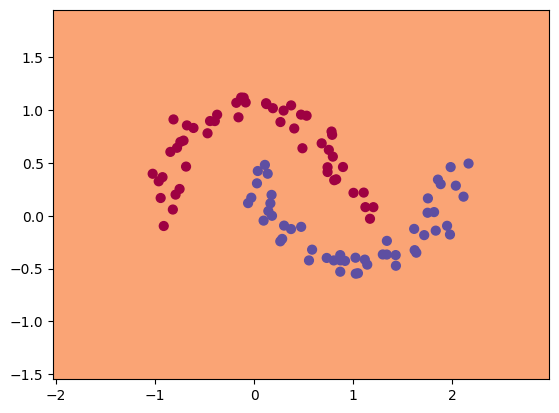

In [8]:
# abschließend können wir das ergebnis unseres modells 
# über unsere eingabedaten zeichnen und erkennen, dass die beiden klasen
# unterschieden werden können

h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = list(map(model, inputs))
Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())


### Aufgaben
#### Aufgabe 1
Vergleiche die Ergebnisse des Modells vor und nach dem Training, wie unterscheidet sich die Decision Boundary, wie viele Punkte werden korrept klassifiziert?
#### Aufgabe 2
Wäre es möglich die Punkte mit linearer Klassifizierung richtig zuzuordnen?